In [1]:
#pip install chess
import chess
import math
import time
import chess.svg
import time
from IPython.display import display, HTML, clear_output
import tensorflow as tf
import numpy as np
import pandas as pd
from collections import OrderedDict
from operator import itemgetter 

In [2]:
import time
path_to_model = 'nmodel1/1620911851'
model = tf.saved_model.load(path_to_model)

In [3]:

def get_board_pieces(board):
    board_pieces = []
    for square in chess.SQUARES:
        board_pieces.append(str(board.piece_at(square)))
    return board_pieces

## return the numeric features of move
def get_move(move):
    from_ = np.zeros(64)
    to_ = np.zeros(64)
    from_[move.from_square] = 1
    to_[move.to_square] = 1
    return from_, to_

##list all possible moves 
##and covnert the board and moves into pandas.dataframe 
def get_possible_moves_data(board):
    data = []
    moves = list(board.legal_moves)
    for move in moves:
        from_, to_ = get_move(move)
        feature = np.concatenate((get_board_pieces(board), from_, to_))
        data.append(feature)
    ##columns name
    board_loc = chess.SQUARE_NAMES
    move_from_loc = ['from_' + square for square in chess.SQUARE_NAMES]
    move_to_loc = ['to_' + square for square in chess.SQUARE_NAMES]
    columns = board_loc + move_from_loc + move_to_loc
    df = pd.DataFrame(data = data, columns = columns)
    #print(df.head())
    for column in move_from_loc:
        df[column] = df[column].astype(float)
    for column in move_to_loc:
        df[column] = df[column].astype(float)
    return df

In [4]:

def predict(df, model):
    col_names = df.columns
    dtypes = df.dtypes
    predictions = []
    for row in df.iterrows():
        example = tf.train.Example()
        for i in range(len(col_names)):
            dtype = dtypes[i]
            col_name = col_names[i]
            value = row[1][col_name]
            if dtype == 'object':
                value = bytes(value, 'utf-8')
                example.features.feature[col_name].bytes_list.value.extend([value])
            elif dtype == 'float':
                example.features.feature[col_name].float_list.value.extend([value])
            elif dtype == 'int':
                example.features.feature[col_name].int64_list.value.extend([value])
        predictions.append(model.signatures['predict'](examples = tf.constant([example.SerializeToString()])))
    return predictions

In [5]:

def find_best_moves(board, model, proportion = 0.5):
    """Return array of the best chess.Move
    
    Keyword arguments:
    current_board -- chess.Board()
    model -- tf.saved_model
    proportion -- proportion of best moves returned
    """
    good_move_percent = []
    moves = list(board.legal_moves)
    df_features = get_possible_moves_data(board)
    predictions = predict(df_features, model)
    
    for prediction in predictions:
        proto_tensor = tf.make_tensor_proto(prediction['probabilities'])
        prob = tf.make_ndarray(proto_tensor)[0][1] ## the possibility of good move e.g 0.8
        good_move_percent.append(prob)
    
    dict_move = dict(zip(moves, good_move_percent))
    dict_move = OrderedDict(sorted(dict_move.items(), key = itemgetter(1), reverse = True))
    
    best_moves = list(dict_move.keys())
 
    return best_moves[0:int(len(best_moves)*proportion)]

df_features = get_possible_moves_data(board1)
predictions = predict(df_features, model)

proto_tensor = tf.make_tensor_proto(prediction['probabilities'])

In [6]:
#board1 = chess.Board()
#board1.pieces(chess.PAWN, chess.WHITE)

In [7]:
def who(player):
    return "White" if player == chess.WHITE else "Black"
def display_board(board, use_svg):
    if use_svg:
        return board._repr_svg_()
    else:
        return "<pre>" + str(board) + "</pre>" 

In [8]:
def play_game(player1, player2, board, visual="svg", pause=0.5):
    """
    playerN1, player2: functions that takes board, return uci move
    visual: "simple" | "svg" | None
    """
    use_svg = (visual == "svg")
    #board = chess.Board()
    try:
        while not board.is_game_over(claim_draw=True):
            if board.turn == chess.WHITE:
                uci = player1(board)
            else:
                uci = player2(board)               
            name = who(board.turn)
            board.push_uci(uci)
            board_stop = display_board(board, use_svg)
            html = "<b>Move %s %s, Play '%s':</b><br/>%s" % (
                       len(board.move_stack), name, uci, board_stop)
            if visual is not None:
                if visual == "svg":
                    clear_output(wait=True)
                display(HTML(html))
                if visual == "svg":
                    time.sleep(pause)
    except KeyboardInterrupt:
        msg = "Game interrupted!"
        return (None, msg, board)
    result = None
    if board.is_checkmate():
        msg = "checkmate: " + who(not board.turn) + " wins!"
        result = not board.turn
    elif board.is_stalemate():
        msg = "draw: stalemate"
    elif board.is_fivefold_repetition():
        msg = "draw: 5-fold repetition"
    elif board.is_insufficient_material():
        msg = "draw: insufficient material"
    elif board.can_claim_draw():
        msg = "draw: claim"
    if visual is not None:
        print(msg)
    return (result, msg, board)

In [9]:
import random
def random_player(board):
    move = random.choice(list(board.legal_moves))
    return move.uci()
def basic_heuristic_player(board):
    moves = list(board.legal_moves)
    for move in moves:
        newboard = board.copy()
        # go through board and return a score
        move.score = heuristic_staticAnalysis(newboard, move, board.turn)
    moves.sort(key=lambda move: move.score, reverse=True) # sort on score
    return moves[0].uci()

In [10]:
import heuristics
def get_heuristic(board):
    scores = 0
    scores += heuristics.materials(board,100)
    scores += heuristics.piece_moves(board,1)
    scores += heuristics.in_check(board,5)
    scores += heuristics.piece_score(board,10)
    return scores

In [11]:
def compMove_prune(board):
    time1 = time.time()
    possible_moves = list(board.legal_moves)
    move_len = len(possible_moves)
    alpha = -9999
    beta = 9999
    bestScore = -9999
    best_move = possible_moves[0]
    for move in possible_moves:
        newboard = board.copy()
        newboard.push(move)
        if move_len > 15:
            score = ab_minimax(newboard,alpha,beta,3,False)
        elif move_len <= 15 and move_len>5:
            score = ab_minimax(newboard,alpha,beta,4,False)
        else: #<=5
            score = ab_minimax(newboard,alpha,beta,5,False)        
        newboard = board.copy()
        if score > bestScore:
            bestScore = score
            bestMove = move
    print("minimax time:",time.time()-time1)        
    return bestMove.uci()

In [12]:
def ab_minimax(board,alpha,beta,depth,isMaximizing):
    #time1= time.time()
    if board.is_checkmate():
        if board.turn: ##it is white turn
            return -9999
        else:
            return 9999
    if depth == 0:
       # print("minimax time:",time.time()-time1)
        return get_heuristic(board)
    elif depth > 2:
        #print("model computing time:",time.time()-time1)
        moves = find_best_moves(board, model, 0.4)
    else:
        moves = list(board.legal_moves)
    if isMaximizing:
        best_score = -9999
        for move in moves:
            newboard = board.copy()
            newboard.push(move)
            score = ab_minimax(newboard,alpha,beta,depth-1, False)
            newboard = board.copy()
            alpha = max(alpha,best_score)
            best_score = max(best_score, score)
            if beta <= alpha:
                return best_score
        return best_score
    else:
        best_score = 9999
        for move in moves:
            newboard = board.copy()
            newboard.push(move)
            score = ab_minimax(newboard,alpha,beta,depth-1, True)
            newboard = board.copy()
            beta = min(beta,best_score)
            best_score = min(best_score, score)
            if beta <= alpha:
                return best_score
        return best_score

In [13]:
#play_game(compMove, compMove_escape, board5, visual='svg', pause=3)

In [ ]:
board1 = chess.Board()
import chess.svg
play_game(compMove_prune,random_player,board1, visual='svg', pause=0.0)

In [26]:
board1

len(list(board1.legal_moves))

29

In [27]:
len(find_best_moves(board1, model, 0.99))

28

In [28]:
moves = find_best_moves(board1, model, 0.8)

In [29]:
moves

[Move.from_uci('f1g1'),
 Move.from_uci('d8d4'),
 Move.from_uci('f1f2'),
 Move.from_uci('f1e1'),
 Move.from_uci('c2c3'),
 Move.from_uci('f1e2'),
 Move.from_uci('c2c4'),
 Move.from_uci('d8g8'),
 Move.from_uci('d8d5'),
 Move.from_uci('d8d6'),
 Move.from_uci('d8e7'),
 Move.from_uci('d8d7'),
 Move.from_uci('d8b6'),
 Move.from_uci('g2g3'),
 Move.from_uci('b2b3'),
 Move.from_uci('d8d3'),
 Move.from_uci('d8c7'),
 Move.from_uci('d8e8'),
 Move.from_uci('g2g4'),
 Move.from_uci('b2b4'),
 Move.from_uci('d8d1'),
 Move.from_uci('d8d2'),
 Move.from_uci('d8f8')]

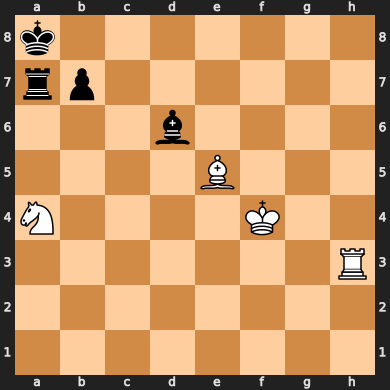

In [30]:
board2 = chess.Board()
chess.Board.clear(board2)
chess.Board.set_piece_at(board2, chess.F4, chess.Piece.from_symbol('K'))
chess.Board.set_piece_at(board2, chess.A8, chess.Piece.from_symbol('k'))

chess.Board.set_piece_at(board2, chess.A4, chess.Piece.from_symbol('N'))
chess.Board.set_piece_at(board2, chess.E5, chess.Piece.from_symbol('B'))
chess.Board.set_piece_at(board2, chess.H3, chess.Piece.from_symbol('R'))



chess.Board.set_piece_at(board2, chess.A7, chess.Piece.from_symbol('r'))
chess.Board.set_piece_at(board2, chess.B7, chess.Piece.from_symbol('p'))
chess.Board.set_piece_at(board2, chess.D6, chess.Piece.from_symbol('b'))


board2


In [31]:
list(board2.legal_moves)

[Move.from_uci('e5d6'),
 Move.from_uci('f4g5'),
 Move.from_uci('f4f5'),
 Move.from_uci('f4g4'),
 Move.from_uci('f4e4'),
 Move.from_uci('f4g3'),
 Move.from_uci('f4f3'),
 Move.from_uci('f4e3'),
 Move.from_uci('a4b6'),
 Move.from_uci('a4c5'),
 Move.from_uci('a4c3'),
 Move.from_uci('a4b2'),
 Move.from_uci('h3h8'),
 Move.from_uci('h3h7'),
 Move.from_uci('h3h6'),
 Move.from_uci('h3h5'),
 Move.from_uci('h3h4'),
 Move.from_uci('h3g3'),
 Move.from_uci('h3f3'),
 Move.from_uci('h3e3'),
 Move.from_uci('h3d3'),
 Move.from_uci('h3c3'),
 Move.from_uci('h3b3'),
 Move.from_uci('h3a3'),
 Move.from_uci('h3h2'),
 Move.from_uci('h3h1')]

In [32]:
moves = find_best_moves(board1, model, 0.7)
moves

[Move.from_uci('f1g1'),
 Move.from_uci('d8d4'),
 Move.from_uci('f1f2'),
 Move.from_uci('f1e1'),
 Move.from_uci('c2c3'),
 Move.from_uci('f1e2'),
 Move.from_uci('c2c4'),
 Move.from_uci('d8g8'),
 Move.from_uci('d8d5'),
 Move.from_uci('d8d6'),
 Move.from_uci('d8e7'),
 Move.from_uci('d8d7'),
 Move.from_uci('d8b6'),
 Move.from_uci('g2g3'),
 Move.from_uci('b2b3'),
 Move.from_uci('d8d3'),
 Move.from_uci('d8c7'),
 Move.from_uci('d8e8'),
 Move.from_uci('g2g4'),
 Move.from_uci('b2b4')]

In [33]:
moves = find_best_moves(board1, model, 0.8)
moves

[Move.from_uci('f1g1'),
 Move.from_uci('d8d4'),
 Move.from_uci('f1f2'),
 Move.from_uci('f1e1'),
 Move.from_uci('c2c3'),
 Move.from_uci('f1e2'),
 Move.from_uci('c2c4'),
 Move.from_uci('d8g8'),
 Move.from_uci('d8d5'),
 Move.from_uci('d8d6'),
 Move.from_uci('d8e7'),
 Move.from_uci('d8d7'),
 Move.from_uci('d8b6'),
 Move.from_uci('g2g3'),
 Move.from_uci('b2b3'),
 Move.from_uci('d8d3'),
 Move.from_uci('d8c7'),
 Move.from_uci('d8e8'),
 Move.from_uci('g2g4'),
 Move.from_uci('b2b4'),
 Move.from_uci('d8d1'),
 Move.from_uci('d8d2'),
 Move.from_uci('d8f8')]